Machine Learning models for obesity risk prediction

In [311]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import math
import sklearn as sk
import xgboost as xgb
from hmmlearn.hmm import GaussianHMM

In [2]:
# Load data
data = pd.read_csv("Data_collection_and_cleaning/processed_data/csv_files/Processed_data.csv",
                   header= 0)

Descriptive analysis

In [3]:
data.head(2)

,subjid,sex,age_days,age_years,date_of_measurement,height_cm,weight_kg,bmi,zbmi,zbmi_type
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,763,2.089023,2015-11-13,87.0,13.2,17.439556,1.24,Overweight
1,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,1118,3.060980,2016-11-02,96.0,15.9,17.252604,1.30,Overweight


In [4]:
print(f"Number of rows: {data.shape[0]}, Number of columns: {data.shape[1]}")

Number of rows: 247663, Number of columns: 10


In [38]:
data.describe()

,age_days,age_years,height_cm,weight_kg,bmi,zbmi
count,247663.000000,247663.000000,247663.000000,247663.000000,247663.000000,247663.000000
mean,2302.077900,6.302875,117.018334,25.911639,17.422402,0.548033
std,1306.740792,3.577735,23.459458,15.057504,3.397402,1.316509
min,731.000000,2.001410,56.000000,4.750000,9.433962,-5.810000
25%,1129.000000,3.091097,97.000000,15.000000,15.231812,-0.340000
50%,2196.000000,6.012444,114.000000,20.400000,16.451348,0.450000
75%,3178.000000,8.701068,134.000000,32.500000,18.518263,1.360000
max,5478.000000,14.998255,202.000000,153.000000,48.836541,10.090000


In [6]:
# Check NA count
data.isna().sum()

subjid                 0
sex                    0
age_days               0
age_years              0
date_of_measurement    0
height_cm              0
weight_kg              0
bmi                    0
zbmi                   0
zbmi_type              0
dtype: int64

In [7]:
data.dtypes

subjid                  object
sex                     object
age_days                 int64
age_years              float64
date_of_measurement     object
height_cm              float64
weight_kg              float64
bmi                    float64
zbmi                   float64
zbmi_type               object
dtype: object

In [16]:
# Number of patients
len(data.subjid.unique())

62798

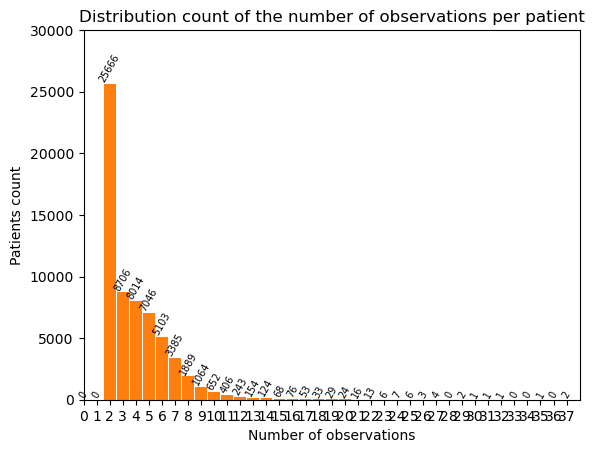

In [9]:
# Plot number of patients by number of obs
n_patients = data.value_counts("subjid")
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 30000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Distribution count of the number of observations per patient")
ax.set_ylabel("Patients count")
ax.set_xlabel("Number of observations")

plt.show()

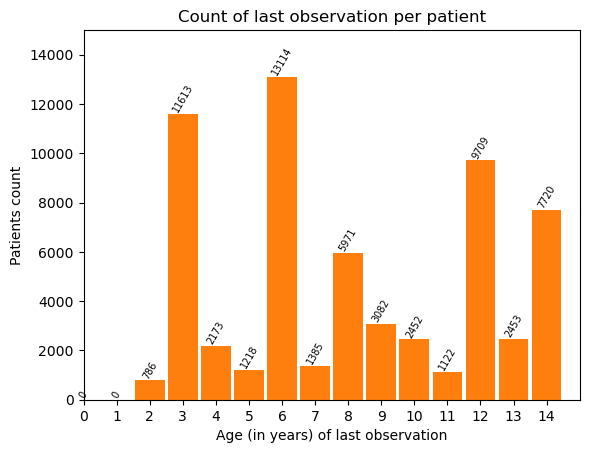

In [10]:
# Plot number of patients by age_years of obs
n_patients = data.groupby("subjid")["age_years"].max().apply(math.trunc)
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 15000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Count of last observation per patient")
ax.set_ylabel("Patients count")
ax.set_xlabel("Age (in years) of last observation")

plt.show()

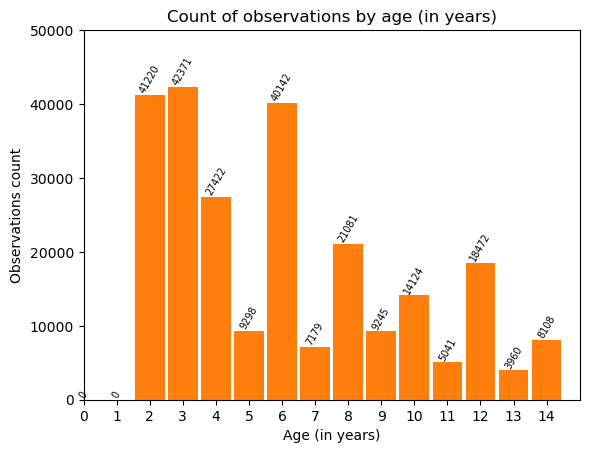

In [11]:
# Plot observations by age_years
n_patients = data.age_years.apply(math.trunc)
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 50000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Count of observations by age (in years)")
ax.set_ylabel("Observations count")
ax.set_xlabel("Age (in years)")

plt.show()

We will consider the following models for comparison: LSTM, GRU, Transformers, Random Forest, XGBoost, HMM, and Gaussian Processes.

To train the models reshaping of our data is needed so we have one row per patient.

In [4]:
# Modify data
data["age_years"] = data["age_years"].apply(math.trunc)
data = data.loc[:, ["subjid", "sex", "age_years", "zbmi", "zbmi_type"]]
data.head(10)

,subjid,sex,age_years,zbmi,zbmi_type
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,2,1.24,Overweight
1,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,3,1.30,Overweight
2,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,4,0.73,Normal_weight
3,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,6,1.52,Overweight
4,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,8,1.70,Overweight
5,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,4,0.79,Normal_weight
6,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,6,0.66,Normal_weight
7,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,8,0.23,Normal_weight
8,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,10,0.59,Normal_weight
9,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,12,0.58,Normal_weight


Analysis of the zbmi trayectories by age:

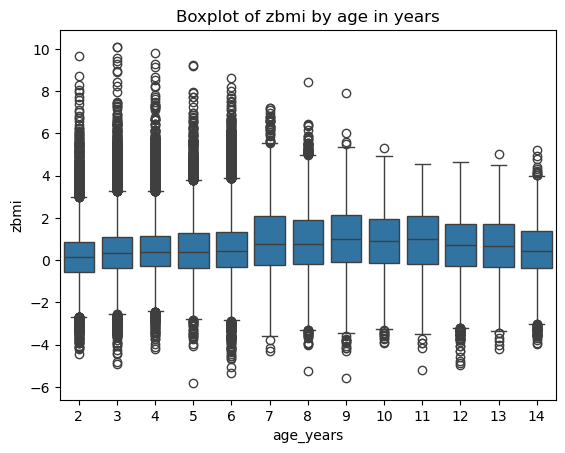

In [4]:
# Plot zbmi by age_years
sns.boxplot(x='age_years', y='zbmi', data=data)
plt.title("Boxplot of zbmi by age in years")
plt.show()

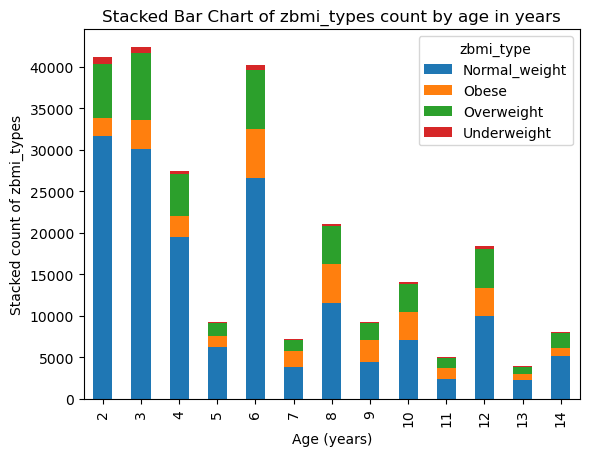

In [4]:
# Bar chart of each zbmi_type by age
stacked_counts = data.groupby(['age_years', 'zbmi_type']).size().unstack(fill_value=0)
stacked_counts.plot(kind='bar', stacked=True)

plt.xlabel('Age (years)')
plt.ylabel('Stacked count of zbmi_types')
plt.title('Stacked Bar Chart of zbmi_types count by age in years')

# Show the plot
plt.show()

In [5]:
# Reshape data
zbmi_pivoted = data.pivot_table(index=["subjid", "sex"], columns="age_years", values="zbmi", aggfunc="mean")
zbmi_types_pivoted = data.pivot_table(index=["subjid", "sex"], columns="age_years", values="zbmi_type", aggfunc="first")

# Combine multilevel columns
zbmi_pivoted.columns = [f"zbmi_{col}" for col in zbmi_pivoted.columns]
zbmi_types_pivoted.columns = [f"zbmi_type_{col}" for col in zbmi_types_pivoted.columns]

# Combine data
pivot_data = pd.merge(zbmi_pivoted, zbmi_types_pivoted, on=["subjid", "sex"], how="inner")
pivot_data.reset_index(inplace=True)

pivot_data.head(5)

,subjid,sex,zbmi_2,zbmi_3,zbmi_4,zbmi_5,zbmi_6,zbmi_7,zbmi_8,zbmi_9,...,zbmi_type_5,zbmi_type_6,zbmi_type_7,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,1.24,1.30,0.73,NaN,1.52,NaN,1.70,NaN,...,NaN,Overweight,NaN,Overweight,NaN,NaN,NaN,NaN,NaN,NaN
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,NaN,NaN,0.79,NaN,0.66,NaN,0.23,NaN,...,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,NaN,NaN,1.43,NaN,1.77,NaN,2.92,3.13,...,NaN,Overweight,NaN,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight
3,++FtKeESpTd0npbWZhKbKwz5udKbtTTDS02C,Female,0.77,1.06,NaN,1.3,NaN,NaN,NaN,NaN,...,Overweight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,++H+79RWVcymBKRpLj7G0Qz5udOavTvIR0uC,Male,NaN,0.63,NaN,NaN,0.83,NaN,NaN,NaN,...,NaN,Normal_weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Add ages again
names = ["age_" + str(x) for x in range(2, 15, 1)]
ages = [x for x in range(2, 15, 1)]
age_dict = dict(zip(names, ages))

for agename, agevalue in age_dict.items():
    pivot_data[agename] = agevalue

# Reorder columns
age_cols = [col for col in pivot_data.columns if 'age' in col]

pivot_data = pivot_data[["subjid", "sex"] + 
                        age_cols + 
                        [col for col in pivot_data.columns if col not in age_cols and col not in ["subjid", "sex"]]]


pivot_data.head(3)

,subjid,sex,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,...,zbmi_type_5,zbmi_type_6,zbmi_type_7,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,2,3,4,5,6,7,8,9,...,NaN,Overweight,NaN,Overweight,NaN,NaN,NaN,NaN,NaN,NaN
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,2,3,4,5,6,7,8,9,...,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,2,3,4,5,6,7,8,9,...,NaN,Overweight,NaN,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight


In [7]:
# Correct labels of zbmi_types
for i in range(2, 15, 1):
    typezbmi = f"zbmi_type_{i}"
    zbmi = f"zbmi_{i}"
    for index, row in pivot_data.iterrows():
        if i < 5:
            match row[zbmi]:
                case value if value < -2.0:
                    pivot_data.at[index, typezbmi] = "Underweight"
                case value if value >= -2.0 and value <= 2.0:
                    pivot_data.at[index, typezbmi] = "Normal_weight"
                case value if value > 2.0 and value <= 3.0:
                    pivot_data.at[index, typezbmi] = "Overweight"
                case value if value > 3.0:
                    pivot_data.at[index, typezbmi] = "Obese"
                case _:
                    pivot_data.at[index, typezbmi] = np.nan
        if i >= 5:
            match row[zbmi]:
                case value if value < -2.0:
                    pivot_data.at[index, typezbmi] = "Underweight"
                case value if value >= -2.0 and value <= 1.0:
                    pivot_data.at[index, typezbmi] = "Normal_weight"
                case value if value > 1.0 and value <= 2.0:
                    pivot_data.at[index, typezbmi] = "Overweight"
                case value if value > 2.0:
                    pivot_data.at[index, typezbmi] = "Obese"
                case _:
                    pivot_data.at[index, typezbmi] = np.nan

In [8]:
# Encode sex variable
from sklearn.preprocessing import OneHotEncoder
sex_encoder = OneHotEncoder(sparse_output=False)
sex_encoded = sex_encoder.fit_transform(pivot_data["sex"].values.reshape(-1, 1))
sex_encoded_df = pd.DataFrame(sex_encoded, columns= sex_encoder.get_feature_names_out(['sex']))
pivot_data = pd.concat([pivot_data, sex_encoded_df], axis=1)

In [9]:
pivot_data.head(3)

,subjid,sex,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,...,zbmi_type_7,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14,sex_Female,sex_Male
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,2,3,4,5,6,7,8,9,...,NaN,Overweight,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,2,3,4,5,6,7,8,9,...,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN,0.0,1.0
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,2,3,4,5,6,7,8,9,...,NaN,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight,0.0,1.0


In [10]:
# Check if the patient number is not affected
len(pivot_data)

62798

Data will be split between 67% train and 33% test, stratifying by sex and zbmi_type_14 label to ensure we
have some final data points in both train and test subsets. Some models need further preparation
after train-test split, so data will be prepared individually in order to maximize performance of
each model.

In [11]:
# Create a temporary column with combination of columns to stratify
pivot_data["stratify"] = pivot_data["sex"].astype(str) + "_" + pivot_data["zbmi_type_14"]
sex_column = pivot_data.pop("sex")

In [14]:
pivot_data.head(10)

,subjid,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,age_10,...,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14,sex_Female,sex_Male,stratify
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,2,3,4,5,6,7,8,9,10,...,Overweight,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,2,3,4,5,6,7,8,9,10,...,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN,0.0,1.0,Unknown
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,2,3,4,5,6,7,8,9,10,...,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight,0.0,1.0,Male_Normal_weight
3,++FtKeESpTd0npbWZhKbKwz5udKbtTTDS02C,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown
4,++H+79RWVcymBKRpLj7G0Qz5udOavTvIR0uC,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,Unknown
5,++I9nc5fKbO/u4b1/2yTiQz5udKYvDzNTkGC,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown
6,++L0bHwVuddtTPbPle9/ggz5uNubsDnCSkyG,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,Overweight,NaN,NaN,1.0,0.0,Unknown
7,++NsVGPHnkdWDpwjB16tQAz5udORsT7CR0GB,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,Obese,NaN,NaN,1.0,0.0,Unknown
8,++PF9XmuTG6SFeJwR1ZiBAz5udKctT7OSk6A,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown
9,++RKhV3ihA/cUyWtQJ+BFQz5udKQsT3CS0GB,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown


In [13]:
# Change stratify NaN to Unknown
pivot_data["stratify"] = pivot_data["stratify"].fillna("Unknown")

In [15]:
zbmi_cols = [f'zbmi_{i}' for i in range(13, 1, -1)]
pivot_data['zbmi_14'] = pivot_data['zbmi_14'].fillna(pivot_data[zbmi_cols].bfill(axis=1).iloc[:, 0])

In [16]:
zbmi_cols.insert(0, 'zbmi_14')

In [17]:
pivot_data[zbmi_cols].head(10)

,zbmi_14,zbmi_13,zbmi_12,zbmi_11,zbmi_10,zbmi_9,zbmi_8,zbmi_7,zbmi_6,zbmi_5,zbmi_4,zbmi_3,zbmi_2
0,1.70,NaN,NaN,NaN,NaN,NaN,1.70,NaN,1.52,NaN,0.73,1.30,1.24
1,0.58,NaN,0.58,NaN,0.59,NaN,0.23,NaN,0.66,NaN,0.79,NaN,NaN
2,0.87,NaN,2.23,NaN,3.00,3.13,2.92,NaN,1.77,NaN,1.43,NaN,NaN
3,1.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.30,NaN,1.06,0.77
4,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.83,NaN,NaN,0.63,NaN
5,1.92,NaN,NaN,NaN,NaN,NaN,NaN,1.92,NaN,NaN,NaN,1.55,NaN
6,1.37,NaN,1.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15
7,2.13,NaN,2.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,0.37,NaN
9,1.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.15,NaN,0.91,0.46


In [18]:
# Train-test split 67%-33%
y = pivot_data.pop("zbmi_14")

zbmis = pivot_data[[col for col in pivot_data.columns if '_type' not in col]]
pivot_data = pivot_data[[col for col in pivot_data.columns if '_type' not in col]]

xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(pivot_data.drop(columns=["age_14"]),
                                                                   y,
                                                                   test_size=0.33,
                                                                   random_state=42,
                                                                   stratify=pivot_data["stratify"])
stratify_column = pivot_data.pop("stratify")

In [19]:
# Dataframe shapes
print(f"Xtrain: number of rows = {xtrain.shape[0]}, number of columns = {xtrain.shape[1]}")
print(f"Xtest: number of rows = {xtest.shape[0]}, number of columns = {xtest.shape[1]}")
print(f"Ytrain: number of rows = {ytrain.shape[0]}")
print(f"Ytest: number of rows = {ytest.shape[0]}")

Xtrain: number of rows = 42074, number of columns = 28
Xtest: number of rows = 20724, number of columns = 28
Ytrain: number of rows = 42074
Ytest: number of rows = 20724


In [24]:
xtrain.head(5)

,subjid,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,age_10,...,zbmi_7,zbmi_8,zbmi_9,zbmi_10,zbmi_11,zbmi_12,zbmi_13,sex_Female,sex_Male,stratify
25106,EiAE5NYdj56uflkYvwqsTQz5udObszrPSECD,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown
36361,MIS7h3GhTWgHCOpWeprnEgz5uNuftD7ISkCH,2,3,4,5,6,7,8,9,10,...,NaN,1.09,NaN,NaN,NaN,1.6600,NaN,1.0,0.0,Unknown
8380,3XG+IdpcK3uf23C+klJUxAz5udKevT3NSUuH,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,1.25,0.3925,NaN,0.0,1.0,Unknown
6827,2Wc8jnptHIashrHcGwZw2wz5uNqdtz/PSkCD,2,3,4,5,6,7,8,9,10,...,NaN,-0.29,NaN,-0.24,NaN,0.3600,NaN,1.0,0.0,Female_Normal_weight
52767,dYFpTzPT7ovK6WoYj+CVJAz5udKYtzXNTkuD,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown


LSTM model

The Long Short Term Memory models need a 3D array as input with the form of samples, time_steps, features. In our case, the samples are the rows, the time_steps are our 12 measurements (zbmi from ages 2 through 13) and features are the value at each time_step, and both sex columns since they are one-hot-encoded.

In [68]:
def lstm_preprocess(df, measure_cols, sex_cols, real_col):
    LSTM_measures = df[measure_cols].values.reshape(-1, len(measure_cols), 1)
    LSTM_sex = df[sex_cols].values
    sex_repeated = np.repeat(LSTM_sex[:, np.newaxis, :], len(measure_cols), axis=1)
    is_real_value = df[real_col].apply(lambda x: 0 if x == "Unknown" else 1).values
    is_real_value = is_real_value.reshape(-1, 1, 1)
    is_real_value = np.repeat(is_real_value, len(measure_cols), axis=1)
    LSTM_combined = np.concatenate([LSTM_measures, sex_repeated, is_real_value], axis=2)
    return LSTM_combined

In [69]:
LSTM_measure_cols = [f"zbmi_{i}" for i in range(2, 14)]
LSTM_xtrain = lstm_preprocess(xtrain, LSTM_measure_cols, ["sex_Female", "sex_Male"], "stratify")
LSTM_xtest = lstm_preprocess(xtest, LSTM_measure_cols, ["sex_Female", "sex_Male"], "stratify")

In [70]:
print(f"LSTM train shape: {LSTM_xtrain.shape}, LSTM test shape: {LSTM_xtest.shape}")

LSTM train shape: (42074, 12, 4), LSTM test shape: (20724, 12, 4)


In [22]:
# LSTM Model
class LSTM_model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.lstm = tf.keras.layers.LSTM(64, return_sequences = True)
        self.lstm2 = tf.keras.layers.LSTM(32, return_sequences = False)
        self.dense32 = tf.keras.layers.Dense(32, activation = "relu")
        self.dense1 = tf.keras.layers.Dense(1, activation = "linear")
        self.mae = tf.keras.metrics.MeanAbsoluteError()
    
    def call(self, inputs, training=False):
        x = self.lstm(inputs)
        x = self.lstm2(x)
        x = self.dense32(x)
        return self.dense1(x)
    
    def compute_weights(self, inputs):
        values = inputs[:, :, 0]
        is_not_nan = ~tf.math.is_nan(values)
        reversed_mask = tf.reverse(is_not_nan, axis=[1])
        last_real_index = tf.argmax(tf.cast(reversed_mask, tf.float32), axis=1)
        last_real_index = 12 - 1 - tf.cast(last_real_index, tf.float32)
        max_distance = tf.constant(12.0)
        recency_weight = 1.0 - (last_real_index / max_distance)
        y_is_real = inputs[:, -1, -1]
        y_is_real = tf.cast(y_is_real, tf.float32)
        return recency_weight * y_is_real

    def compute_real_mae(self, y_true, y_pred, is_real):
        is_real = tf.cast(is_real, tf.float32)  # (batch,)
        abs_error = tf.abs(y_true - y_pred)     # (batch, 1)
        masked_error = abs_error * is_real[:, tf.newaxis]  # apply mask

        total_error = tf.reduce_sum(masked_error)
        count = tf.reduce_sum(is_real)
        return total_error / (count + 1e-6)

    def train_step(self, data):
        inputs, y_true = data
        y_is_real = inputs[:, -1, -1]

        with tf.GradientTape() as tape:
            y_pred = self(inputs, training = True)
            weights = self.compute_weights(inputs)
            loss = tf.reduce_mean(tf.abs(y_true - y_pred) * weights[:, tf.newaxis])
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.mae.update_state(y_true, y_pred)
        real_mae = self.compute_real_mae(y_true, y_pred, y_is_real)
        
        return {"loss": loss, "mae": self.mae.result(), "real_mae": real_mae}

In [23]:
# Instantiate, compile and fit model
lstm_model = LSTM_model()
lstm_model.compile(optimizer = "adam")
LSTM_history = lstm_model.fit(LSTM_xtrain, ytrain, epochs = 10, batch_size = 32)

Epoch 1/10
1315/1315 [==============================] - 30s 16ms/step - loss: 0.5023 - mae: 1.0792 - real_mae: 1.0623
Epoch 2/10
1315/1315 [==============================] - 16s 12ms/step - loss: 0.4982 - mae: 1.0380 - real_mae: 1.0487
Epoch 3/10
1315/1315 [==============================] - 21s 16ms/step - loss: 0.4982 - mae: 1.0454 - real_mae: 1.0492
Epoch 4/10
1315/1315 [==============================] - 14s 11ms/step - loss: 0.4982 - mae: 1.0408 - real_mae: 1.0491
Epoch 5/10
1315/1315 [==============================] - 12s 9ms/step - loss: 0.4982 - mae: 1.0407 - real_mae: 1.0487
Epoch 6/10
1315/1315 [==============================] - 12s 9ms/step - loss: 0.4982 - mae: 1.0398 - real_mae: 1.0492
Epoch 7/10
1315/1315 [==============================] - 12s 9ms/step - loss: 0.4982 - mae: 1.0432 - real_mae: 1.0490
Epoch 8/10
1315/1315 [==============================] - 12s 9ms/step - loss: 0.4983 - mae: 1.0303 - real_mae: 1.0484
Epoch 9/10
1315/1315 [==============================] - 12s 

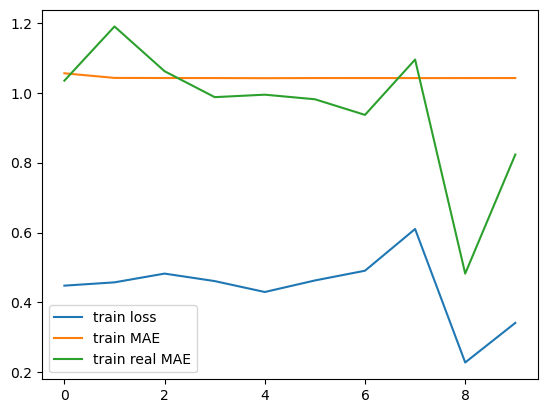

In [24]:
plt.plot(LSTM_history.history['loss'], label='train loss')
plt.plot(LSTM_history.history['mae'], label='train MAE')
plt.plot(LSTM_history.history['real_mae'], label='train real MAE')
plt.legend()
plt.show()

In [25]:
LSTM_loss, LSTM_accuracy = lstm_model.evaluate(LSTM_xtest, ytest)

648/648 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00


Test Sequential LSTM

In [71]:
testlstm_xtrain = np.nan_to_num(LSTM_xtrain, nan=999.0)
testlstm_xtest = np.nan_to_num(LSTM_xtest, nan=999.0)
testlstm_model = tf.keras.models.Sequential()
testlstm_model.add(tf.keras.layers.Input(shape=(12, 4)))
testlstm_model.add(tf.keras.layers.Masking(mask_value=999.0))
testlstm_model.add(tf.keras.layers.LSTM(64))
testlstm_model.add(tf.keras.layers.Dense(1, activation='linear'))
testlstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [72]:
testLSTM_model = testlstm_model.fit(testlstm_xtrain, ytrain, epochs=10, batch_size=32, validation_split = 0.2)

Epoch 1/10
1052/1052 [==============================] - 17s 10ms/step - loss: 0.3272 - mae: 0.3156 - val_loss: 0.0621 - val_mae: 0.1227
Epoch 2/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0583 - mae: 0.1125 - val_loss: 0.0524 - val_mae: 0.1014
Epoch 3/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0517 - mae: 0.0981 - val_loss: 0.0494 - val_mae: 0.0896
Epoch 4/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0494 - mae: 0.0928 - val_loss: 0.0517 - val_mae: 0.1081
Epoch 5/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0484 - mae: 0.0918 - val_loss: 0.0471 - val_mae: 0.0866
Epoch 6/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0476 - mae: 0.0891 - val_loss: 0.0494 - val_mae: 0.1064
Epoch 7/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0476 - mae: 0.0901 - val_loss: 0.0477 - val_mae: 0.0900
Epoch 8/10
1052/1052 [==============================] - 8s 8

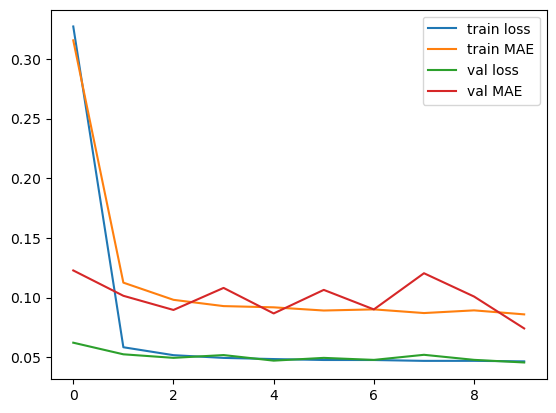

In [73]:
plt.plot(testLSTM_model.history['loss'], label='train loss')
plt.plot(testLSTM_model.history['mae'], label='train MAE')
plt.plot(testLSTM_model.history['val_loss'], label='val loss')
plt.plot(testLSTM_model.history['val_mae'], label='val MAE')
plt.legend()
plt.show()

GRU

In [74]:
GRU_xtrain = np.nan_to_num(LSTM_xtrain, nan=999.0)
GRU_xtest = np.nan_to_num(LSTM_xtest, nan=999.0)

In [75]:
gru_model = tf.keras.models.Sequential()
gru_model.add(tf.keras.layers.Input(shape=(12, 4)))
gru_model.add(tf.keras.layers.Masking(mask_value=999.0))
gru_model.add(tf.keras.layers.GRU(64))
gru_model.add(tf.keras.layers.Dense(1, activation='linear'))
gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [76]:
GRU_model = gru_model.fit(GRU_xtrain, ytrain, epochs=10, batch_size=32, validation_split = 0.2)

Epoch 1/10
1052/1052 [==============================] - 16s 10ms/step - loss: 0.2070 - mae: 0.2166 - val_loss: 0.0548 - val_mae: 0.1002
Epoch 2/10
1052/1052 [==============================] - 9s 8ms/step - loss: 0.0531 - mae: 0.1014 - val_loss: 0.0506 - val_mae: 0.0976
Epoch 3/10
1052/1052 [==============================] - 8s 7ms/step - loss: 0.0501 - mae: 0.0959 - val_loss: 0.0472 - val_mae: 0.0791
Epoch 4/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0483 - mae: 0.0925 - val_loss: 0.0466 - val_mae: 0.0812
Epoch 5/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0476 - mae: 0.0899 - val_loss: 0.0484 - val_mae: 0.0895
Epoch 6/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0469 - mae: 0.0872 - val_loss: 0.0470 - val_mae: 0.0912
Epoch 7/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0468 - mae: 0.0885 - val_loss: 0.0492 - val_mae: 0.1079
Epoch 8/10
1052/1052 [==============================] - 8s 8

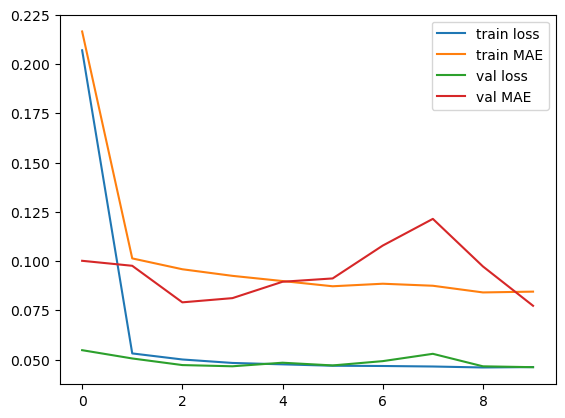

In [77]:
plt.plot(GRU_model.history['loss'], label='train loss')
plt.plot(GRU_model.history['mae'], label='train MAE')
plt.plot(GRU_model.history['val_loss'], label='val loss')
plt.plot(GRU_model.history['val_mae'], label='val MAE')
plt.legend()
plt.show()

In [78]:
gru_loss, gru_accuracy = gru_model.evaluate(GRU_xtest, ytest)

648/648 [==============================] - 2s 3ms/step - loss: 0.0449 - mae: 0.0760


Transformers

Random Forest

In [233]:
# Optimize dataset for RF model
cols_for_RF = [*["zbmi_" + str(i) for i in range(2, 14, 1)], "sex_Female", "sex_Male", "stratify"]
RF_xtrain = xtrain[cols_for_RF].copy()
RF_xtest = xtest[cols_for_RF].copy()

In [179]:
RF_xtest.head(10)

,zbmi_2,zbmi_3,zbmi_4,zbmi_5,zbmi_6,zbmi_7,zbmi_8,zbmi_9,zbmi_10,zbmi_11,zbmi_12,zbmi_13,sex_Female,sex_Male,stratify
37862,NaN,1.76,NaN,NaN,3.82,4.77,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,Unknown
45979,0.13,-0.14,-0.52,NaN,-0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,Unknown
60695,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,Unknown
5888,4.15,4.64,3.85,3.30,3.19,4.21,3.27,NaN,NaN,NaN,2.703333,NaN,0.0,1.0,Unknown
32340,NaN,1.44,NaN,1.73,1.57,NaN,1.32,NaN,1.27,NaN,1.680000,NaN,1.0,0.0,Female_Overweight
8224,0.83,1.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,Unknown
24921,NaN,NaN,NaN,0.12,-0.17,NaN,NaN,0.18,NaN,NaN,-0.990000,NaN,1.0,0.0,Female_Normal_weight
21678,-1.21,NaN,-2.02,NaN,-2.58,-1.87,NaN,NaN,-2.77,NaN,-3.410000,NaN,0.0,1.0,Male_Underweight
204,0.22,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown
3850,NaN,NaN,NaN,NaN,-0.38,NaN,NaN,NaN,NaN,NaN,-0.030000,NaN,0.0,1.0,Male_Normal_weight


In [234]:
RF_xtrain.loc[:, "stratify"] = RF_xtrain["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)
RF_xtest.loc[:, "stratify"] = RF_xtest["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)

RF_xtrain["stratify"] = RF_xtrain["stratify"].astype(float)
RF_xtest["stratify"] = RF_xtest["stratify"].astype(float)

In [235]:
def process_cols_RF(df):
    df = df.copy()
    for i in range(2, 14, 1):
        zbmi_col = "zbmi_" + str(i)
        missing_col = "missing_zbmi_" + str(i)
        df.loc[:, missing_col] = df[zbmi_col].apply(lambda x: 1 if pd.isna(x) else 0)
        df.loc[:, zbmi_col] = df[zbmi_col].fillna(999.0)

    return df

In [236]:
RF_xtrain = process_cols_RF(RF_xtrain)
RF_xtest = process_cols_RF(RF_xtest)

In [238]:
RF_xtrain.head(10)

,zbmi_2,zbmi_3,zbmi_4,zbmi_5,zbmi_6,zbmi_7,zbmi_8,zbmi_9,zbmi_10,zbmi_11,...,missing_zbmi_4,missing_zbmi_5,missing_zbmi_6,missing_zbmi_7,missing_zbmi_8,missing_zbmi_9,missing_zbmi_10,missing_zbmi_11,missing_zbmi_12,missing_zbmi_13
25106,0.87,1.67,999.00,999.00,999.00,999.0,999.00,999.0,999.00,999.00,...,1,1,1,1,1,1,1,1,1,1
36361,999.00,999.00,0.44,999.00,0.81,999.0,1.09,999.0,999.00,999.00,...,0,1,0,1,0,1,1,1,0,1
8380,999.00,999.00,999.00,999.00,999.00,999.0,999.00,999.0,999.00,1.25,...,1,1,1,1,1,1,1,0,0,1
6827,999.00,999.00,999.00,999.00,0.45,999.0,-0.29,999.0,-0.24,999.00,...,1,1,0,1,0,1,0,1,0,1
52767,999.00,999.00,1.05,1.79,999.00,999.0,999.00,999.0,999.00,999.00,...,0,0,1,1,1,1,1,1,1,1
47167,999.00,1.28,1.34,999.00,1.04,999.0,999.00,999.0,999.00,999.00,...,0,1,0,1,1,1,1,1,1,1
60880,1.68,0.83,999.00,999.00,999.00,999.0,999.00,999.0,999.00,999.00,...,1,1,1,1,1,1,1,1,1,1
43668,999.00,-0.97,999.00,999.00,1.11,999.0,1.40,999.0,1.58,999.00,...,1,1,0,1,0,1,0,1,0,1
17764,999.00,999.00,2.69,999.00,1.70,999.0,999.00,999.0,999.00,999.00,...,0,1,0,1,1,1,1,1,1,1
62483,999.00,1.09,999.00,999.00,0.42,999.0,999.00,999.0,999.00,999.00,...,1,1,0,1,1,1,1,1,1,1


In [239]:
RF_model = sk.ensemble.RandomForestRegressor(
    n_estimators = 100,
    max_depth = None,
    random_state = 42,
    n_jobs = -1)

In [240]:
RF_model.fit(RF_xtrain, ytrain)

RandomForestRegressor(n_jobs=-1, random_state=42)

XGBoost

In [241]:
# Optimize dataset for XGBoost model
cols_for_XGBoost = [*["zbmi_" + str(i) for i in range(2, 14, 1)], "sex_Female", "sex_Male", "stratify"]
XGBoost_xtrain = xtrain[cols_for_XGBoost].copy()
XGBoost_xtest = xtest[cols_for_XGBoost].copy()

XGBoost_xtrain.loc[:, "stratify"] = XGBoost_xtrain["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)
XGBoost_xtest.loc[:, "stratify"] = XGBoost_xtest["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)

XGBoost_xtrain["stratify"] = XGBoost_xtrain["stratify"].astype(float)
XGBoost_xtest["stratify"] = XGBoost_xtest["stratify"].astype(float)

In [242]:
XGBoost_xtest.head(10)

,zbmi_2,zbmi_3,zbmi_4,zbmi_5,zbmi_6,zbmi_7,zbmi_8,zbmi_9,zbmi_10,zbmi_11,zbmi_12,zbmi_13,sex_Female,sex_Male,stratify
37862,NaN,1.76,NaN,NaN,3.82,4.77,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0
45979,0.13,-0.14,-0.52,NaN,-0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0
60695,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0
5888,4.15,4.64,3.85,3.30,3.19,4.21,3.27,NaN,NaN,NaN,2.703333,NaN,0.0,1.0,1.0
32340,NaN,1.44,NaN,1.73,1.57,NaN,1.32,NaN,1.27,NaN,1.680000,NaN,1.0,0.0,0.0
8224,0.83,1.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0
24921,NaN,NaN,NaN,0.12,-0.17,NaN,NaN,0.18,NaN,NaN,-0.990000,NaN,1.0,0.0,0.0
21678,-1.21,NaN,-2.02,NaN,-2.58,-1.87,NaN,NaN,-2.77,NaN,-3.410000,NaN,0.0,1.0,0.0
204,0.22,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0
3850,NaN,NaN,NaN,NaN,-0.38,NaN,NaN,NaN,NaN,NaN,-0.030000,NaN,0.0,1.0,0.0


In [243]:
XGBoost_xtrain.dtypes

zbmi_2        float64
zbmi_3        float64
zbmi_4        float64
zbmi_5        float64
zbmi_6        float64
zbmi_7        float64
zbmi_8        float64
zbmi_9        float64
zbmi_10       float64
zbmi_11       float64
zbmi_12       float64
zbmi_13       float64
sex_Female    float64
sex_Male      float64
stratify      float64
dtype: object

In [244]:
XGB_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    missing=np.nan,
    random_state=42
)

In [245]:
XGB_model.fit(XGBoost_xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Hidden Markov Models

In [315]:
# Optimize dataset for HMM
cols_to_fill = ["zbmi_" + str(i) for i in range(2, 14, 1)]
cols_for_HMM = [*["zbmi_" + str(i) for i in range(2, 14, 1)], "sex_Female", "sex_Male", "stratify"]
HMM_xtrain = xtrain[cols_for_HMM].copy()
HMM_xtest = xtest[cols_for_HMM].copy()

HMM_xtrain.loc[:, "stratify"] = HMM_xtrain["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)
HMM_xtest.loc[:, "stratify"] = HMM_xtest["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)

HMM_xtrain["stratify"] = HMM_xtrain["stratify"].astype(float)
HMM_xtest["stratify"] = HMM_xtest["stratify"].astype(float)

In [314]:
def hmm_preprocess(df, measure_cols):
    df = df.copy()
    df = df.ffill(axis = 1)
    df = df.bfill(axis = 1)
    HMM_measures = df[measure_cols].values.reshape(-1, len(measure_cols))
    HMM_combined = np.array(HMM_measures)
    return HMM_combined

In [316]:
HMM_xtrain = hmm_preprocess(HMM_xtrain, cols_for_HMM)
HMM_xtest = hmm_preprocess(HMM_xtest, cols_for_HMM)

In [317]:
print(f"HMM xtrain shape: {HMM_xtrain.shape}, HMM test shape: {HMM_xtest.shape}")

HMM xtrain shape: (42074, 15), HMM test shape: (20724, 15)


In [319]:
# HMM model
HMM_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)

In [320]:
HMM_model.fit(HMM_xtrain)

c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\admin\anaconda3\envs\tfm_ml\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\admin\anaconda3\envs\tfm_ml\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\admin\anaconda3\envs\tfm_ml\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.Create

GaussianHMM(covariance_type='full', n_components=2, n_iter=1000)

Gaussian Processes